# 03 E-Commerce Recommendations

Product recommendations powered by vector search help E-commerce merchants offer relevant and personalized shopping experiences, improving clients' experience site-wide.

Throughout this tutorial, we will guide you through the journey to create a basic E-commerce recommendations application using Vecto.

## Setting up Vecto Working Environment 

In [ ]:
!pip install ftfy tqdm requests pillow ipywidgets pandas

In [ ]:
import requests
from ipywidgets import interact_manual, IntSlider, FileUpload
import pathlib
import pandas as pd
from IPython.display import display, HTML
import math
from tqdm.notebook import tqdm
import io
import json
import re

## Creating Vector Space

1. Access the Vecto login page at <[Vecto Login](https://app.vecto.ai/login.xhtml)>, insert your *Username* and *Password* and click Sign In. 
   
2. From the admin page sidebar, select the **Dashboard** tab and click on *Create new vector space*. Fill in the Vector Space name; in this case, we will call it `e_commerce_recommendation`. You will then be able to choose a `vectorization model`. As we are going to work with both images and text, choose the [CLIP](https://github.com/openai/CLIP) model. Finally, click the `Create Vector Space` button. You can view your Vector Space details by clicking on the Vector Space name in the Vector Spaces list. Take note on your Vector Space ID to use in a later step. 
    
3. In order to access the vector space, we will need to create a Vector Space authentication token. Click on the **Tokens** tab in the sidebar, set the token name to `e_commerce_recommendation_token`, and then select the Vector Space `e_commerce_recommendation` that we created earlier, click on `Create User Token`. Click on your token name in the list to view it. This token will be used to authenticate access to Vecto servers. Copy the token to use in the next step. Here we go! Now you have your first Vector Space.


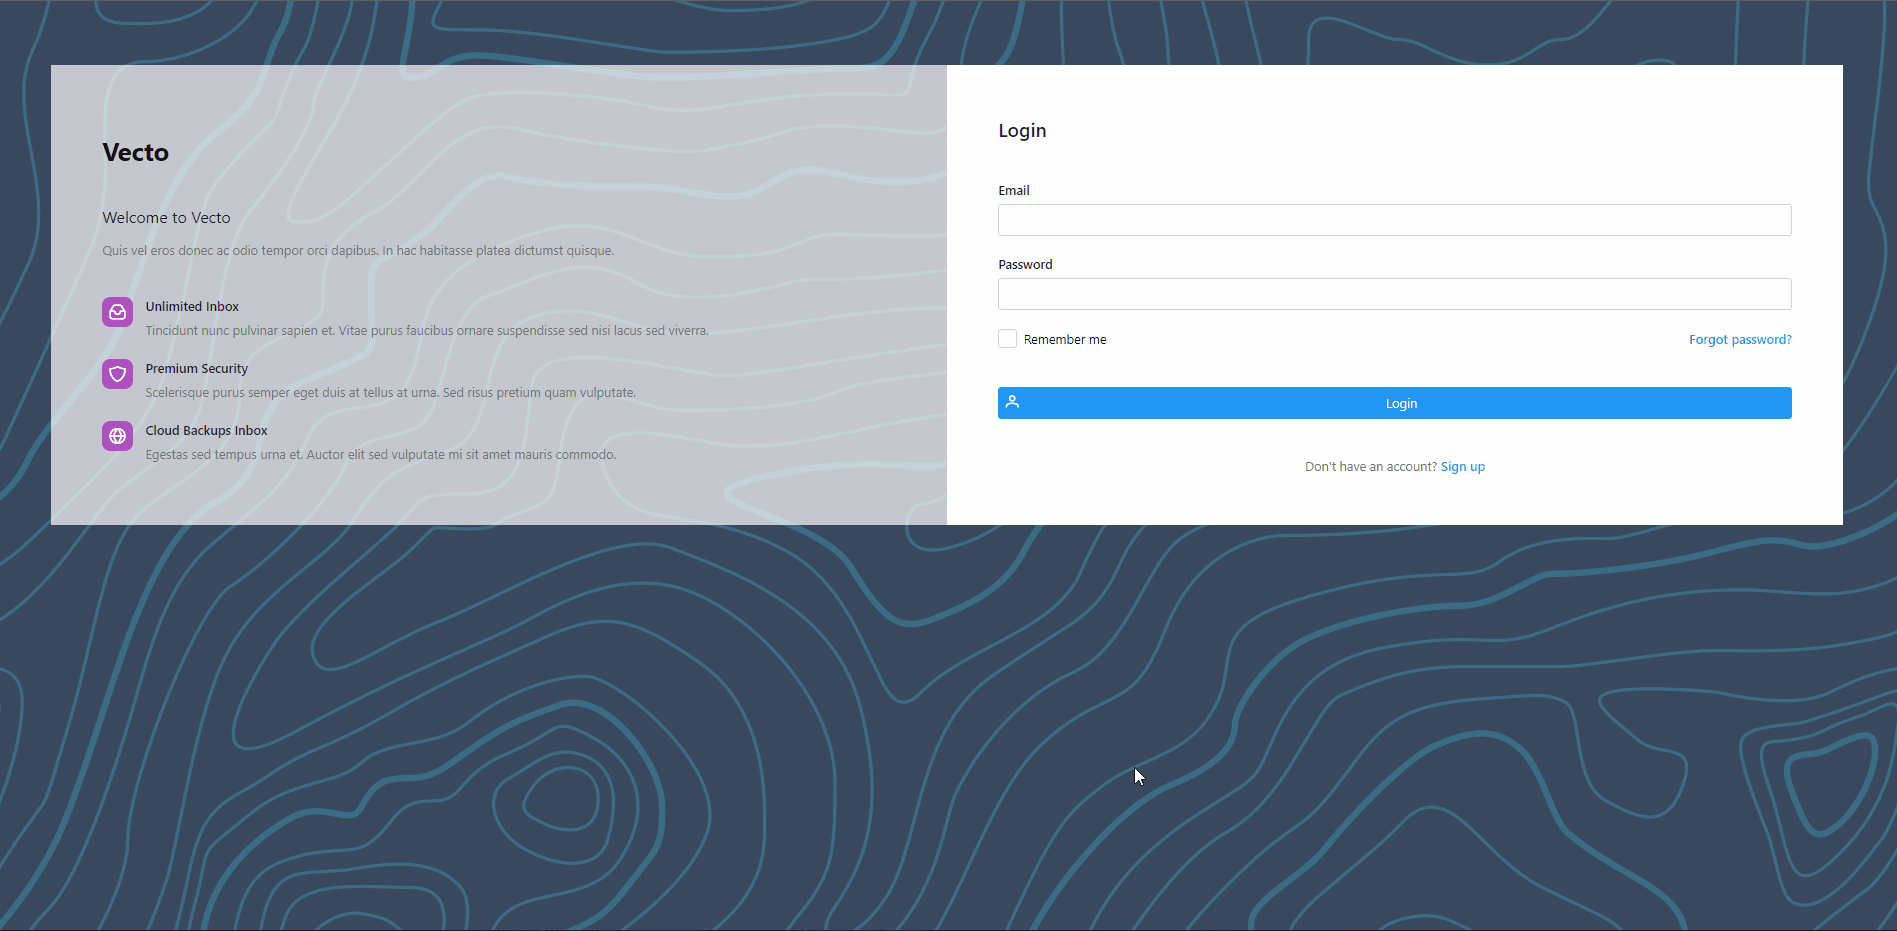

## Add and Ingest Data into Vector Space

 To start, let's initialize the Vecto API end-point and pass our `e_commerce_recommendation` Vector Space ID and authentication token. Copy the below cell into your notebook 2nd cell and insert the values for the `token` and `vecto_space_id`, then run the cell.

In [ ]:
vecto_base_url ="https://api.vecto.ai/api/v0"
token = ""
vector_space_id = ""

Please note that the Vector Space ID and token are unique for every Vector Space. You refer to the [previous step](#creating-vector-space) if you can not find your `e_commerce_recommendation` Vector Space ID or token. 

### Dataset

In this Tutorial, we are using the [Flipkart Products dataset from Kaggle](https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products). This dataset has details for around 20,000 different product listings on FlipKart website. 

To proceed, you must download and extract the dataset into the working directory `vecto_ecommerce_demo`.

Now your working directory should look like this:
```
|__vecto_ecommerce_demo
    |__requirements.txt
    |__e_commerce_demo.ipynb
    |__flipkart_com-ecommerce_sample.csv
```
Now, let's read the dataset's `.csv` file. Here, we are interested in vectorizing the `product_name` and `description` columns; we will drop any product without `product_name` and `description` and concatenate the texts in both columns into a new `product_details` column. Additionally, we will convert the `image` column to a list of URLs for easier online retrieval of the product images. Finally, we will collect the `product_details` column and the indexes into Python lists:    

In [ ]:
text_data = pd.read_csv('flipkart_com-ecommerce_sample.csv').dropna(subset=['product_name','description'])
text_data['product_details'] = text_data['product_name'].astype(str) +" "+ text_data['description'].astype(str) 
raw_text_list = text_data['product_details'].tolist()
index_list = text_data.index.tolist()
text_data["image"] = text_data["image"].apply(lambda x: json.loads(x) if type(x) == str else [])

The text descriptions in the `raw_text_list` require some pre-processing to remove any special characters or extra spaces between the words. We will use the following code to achieve that:    

In [ ]:
text_list = []
for i in raw_text_list:
    text = (i.rstrip('\n')).replace('\n','')
    text = (text.rstrip('\t')).replace('\t','')
    text = re.sub('[^\w]',' ', text)
    text = re.sub('\s+',' ',text)
    text_list.append(text)

### Vectorize text data

To ingest the texts descriptions in the `text_list` list into our `e_commerce_recommendation` Vector Space, we will need a few helper functions to split the texts ingesting process into batches, let's add the two functions `ingest_text_batch` and `ingest_all_text` to our `e_commerce_demo` notebook: 

In [ ]:
def ingest_text_batch(batch_path_list,batch_text_list):
    data = {'vector_space_id': vector_space_id, 'data': [], 'modality': 'TEXT'}
    files = []
    for path in batch_path_list:
        data['data'].append(path)
    result = requests.post("%s/index" % vecto_base_url,
                  data=data,
                  files=[('input', ('_', f, '_')) for f in batch_text_list],
                  headers={"Authorization":"Bearer %s" %token})

    for f in files:
        f.close()

In [ ]:
def ingest_all_text(path_list,text_list, batch_size=64):
    batch_count = math.ceil(len(path_list) / batch_size)
    batches_path = [path_list[i * batch_size: (i + 1) * batch_size] for i in range(batch_count)]
    batches_text = [text_list[i * batch_size: (i + 1) * batch_size] for i in range(batch_count)]
    for batch,text in tqdm(zip(batches_path,batches_text), total = len(batches_path)):
        ingest_text_batch(batch,text)

The batch size determines the number of texts ingested in each batch. Here, we set the batch size to `256` to speed up the initial ingest process. However, batch size could be set to any other integer value, even just `1`, as this is merely depending on the dataset type and size.

In [ ]:
ingest_all_text(index_list,text_list,batch_size=256)

Here we go! your current vector space holds all the products text descriptions embeddings. 


## Vector Search image/text Queries

After ingesting the dataset into the `e_commerce_recommendation` vector space, now let's try to perform a different type of vector search query using text or images. For that, we will use a few helper functions to handle the mentioned processes. Let's add these four functions `display_results`, `lookup`, `text_query`, and`image_query` to our `e_commerce_demo` notebook: 

In [ ]:
def display_results(results):
    output = []
    for result in results:
        output.append("Similarity: %s" % result['similarity'])
        image = text_data['image'][int(result['data'])][0]
        image = HTML('<img src=%s width="300" height="500">'% image)
        output.append(image)
        text = text_data['product_details'][int(result['data'])]
        output.append(text)
    display(*output)

In [ ]:
def lookup(f, modality, top_k):
    result = requests.post("%s/lookup" % vecto_base_url,
                           data={'vector_space_id': vector_space_id, 'modality': modality, 'top_k': top_k},
                           files={'query': f},
                           headers={"Authorization":"Bearer %s" %token})

    results = result.json()['results']
    display_results(results)

In [ ]:
def text_query(query, top_k=10):
    f = io.StringIO(query)
    lookup(f, 'TEXT', top_k)

def image_query(query, top_k=10):
    f = io.BytesIO(query[0]['content'])
    lookup(f, 'IMAGE', top_k)

Now all is ready to try a few vector search queries!

First, let's start with some text queries. Using the interactive cell widget, you could:
-  Type your query text in the available text box.
-  Select the number of results with the highest search similarity to view `top_k`.

For example, we will type *Round Neck T-Shirt* as our text query, and we expect the vector search to return more Round Neck T-Shirt products from the vector space.  

In [ ]:
interact_manual(text_query, query="Round Neck T-Shirt", top_k=IntSlider(min=1, max=50))

After you insert the above line into the `e_commerce_demo` notebook, you are expected to see the following output when you query *Round Neck T-Shirt* and set the *top_k* to 4. Click the `Run Interact` button to start the vector search.

Now similarly, let's try image queries. Using the interactive cell widget, you could:
-  Upload your query image using the Upload button.
-  Select the number of results with the highest search similarity to view `top_k`.

As an example, we will upload an image of a black T-shirt downloaded from [Unsplash](https://unsplash.com/photos/6Nub980bI3I) as our image query. We would expect the vector search to return texts description for black T-shirt products from the vector space.  

<div>
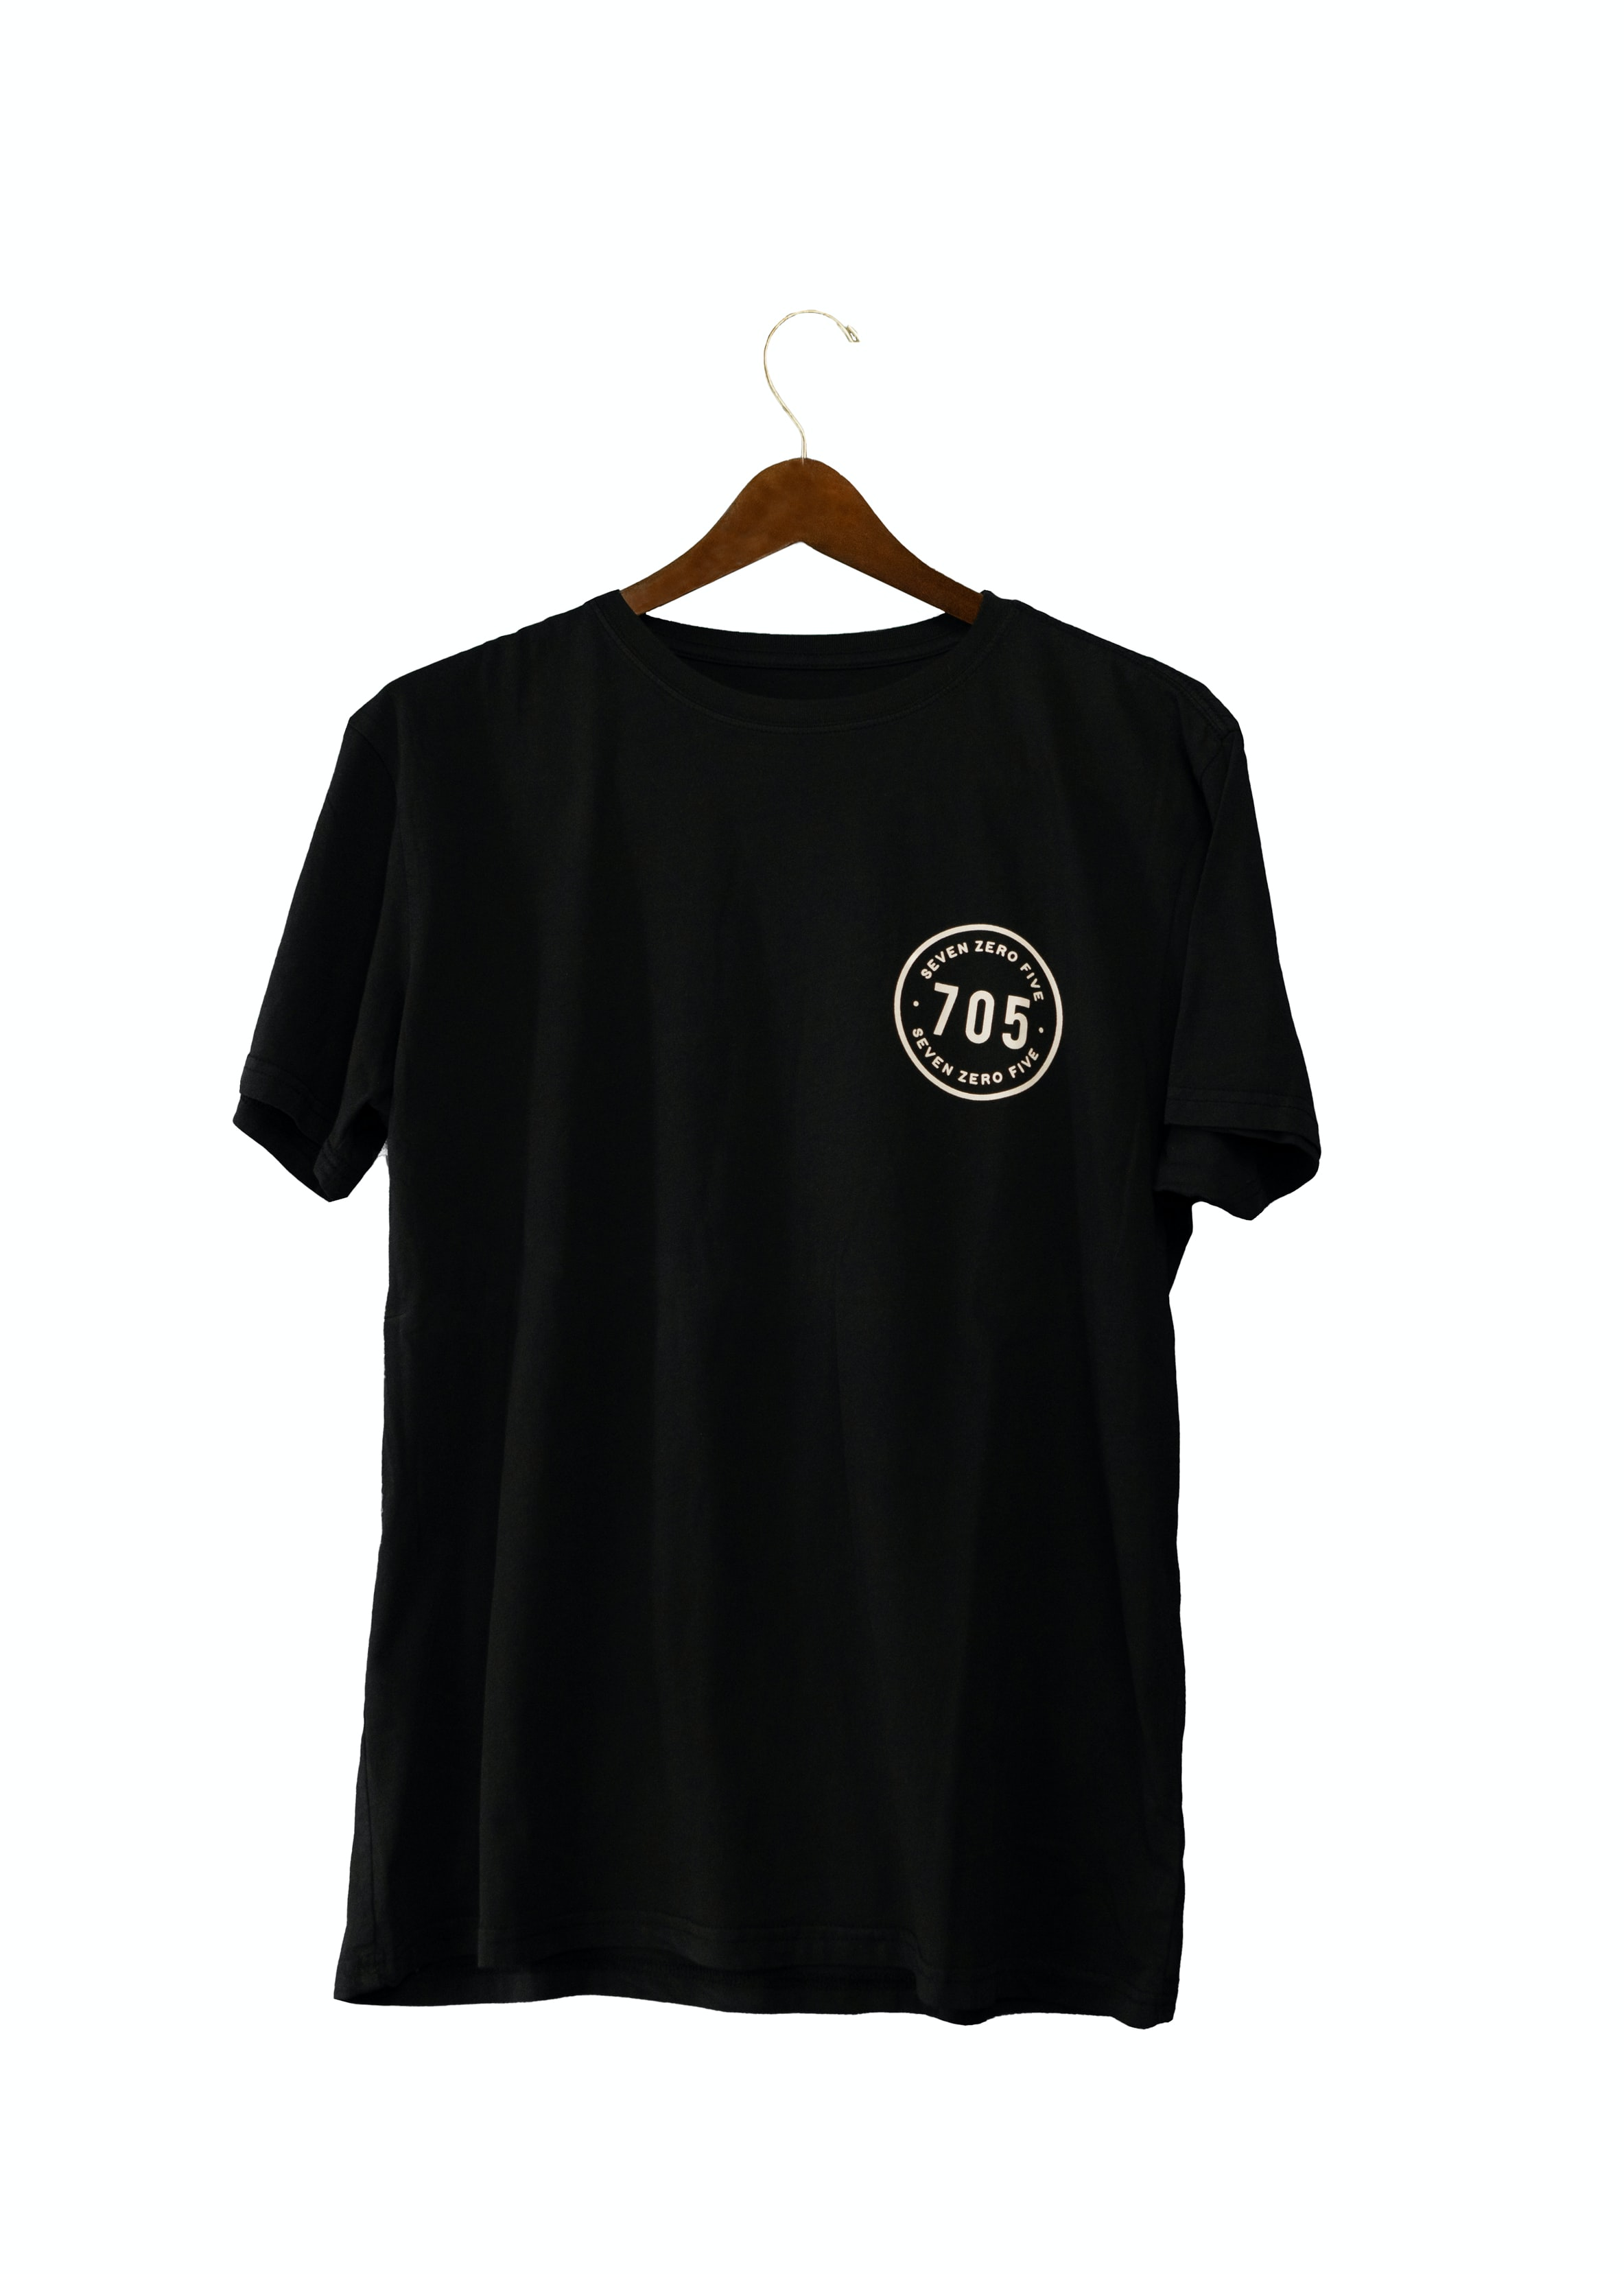
</div>

In [ ]:
interact_manual(image_query, query=FileUpload(multiple=False), top_k=IntSlider(min=1, max=50))

After you insert the above line into the `e_commerce_demo` notebook, you are expected to see the following widget, upload the image and click the `Run Interact` button to start the vector search.

## Create a Vector Search Analogy

A surprising property of vectors is that we can solve analogies with vector arithmetic. Taking `Summer is to Winter as is T-Shirt is to Sweater` as an analogy. We could use the vector difference **Summer vector - Winter vector** as an analogy vector to modify the vector search output for the *T-Shirt* query from returning more T-shirts products as we saw in the [earlier](#vector-search-imagetext-queries) to returning Winter clothes like sweaters instead. The overall arithmetic equation that governs such an analogy can be represented as follows:

<p align="center">
Let <strong>Summer - Winter = T-Shirt - Sweater</strong> <br></br> 
Therefore, <strong>Winter - Summer + T-Shirt = Sweater</strong>
</p>


First, let's add this helper functions `analogy`,`text_analogy` and `image_analogy` to our notebook:

In [ ]:
def analogy(query, start, end, modality, top_k):
    result = requests.post("%s/analogy" % vecto_base_url,
                           data={'vector_space_id': vector_space_id, 'modality': modality, 'top_k': top_k},
                           files={'query': query, 'from': start, 'to': end},
                           headers={"Authorization":"Bearer %s" %token})

    results = result.json()['results']
    display_results(results)

In [ ]:
def text_analogy(query, start, end, top_k=10):
    analogy(io.StringIO(query), io.StringIO(start), io.StringIO(end), 'TEXT', top_k)

In [ ]:
def image_analogy(query, start, end, top_k=10):
    analogy(
        io.BytesIO(query[0]['content']),
        io.BytesIO(start[0]['content']),
        io.BytesIO(end[0]['content']),
        'IMAGE',
        top_k
    )

Now all is ready, let's see if our analogy is working. 

First, let's start with some text analogy. Using the interactive cell widget, you could:
-  Type analogy *start*, *end* and *query* text in the available text boxes.
-  Select the number of results with the highest search similarity to view `top_k`.

In [ ]:
interact_manual(text_analogy, query="Round Neck T-Shirt", start="summer", end="winter", top_k=IntSlider(min=1, max=50))

After you insert the above line into the `e_commerce_demo` notebook, you are expected to see the following output, set your **query** to *Round Neck T-Shirt* and set the analogy **start** and **end** to *summer* and *winter* respectively, click the `Run Interact` button to start the vector search with the analogy.

Now similarly, let's construct the analogy using images. 

Using the interactive cell widget, you could:
-  upload images for analogy *start*, *end* and *query* image using the upload button for each field.
-  Select the number of results with the highest search similarity to view `top_k`.

In [ ]:
interact_manual(image_analogy, query=FileUpload(multiple=False), start=FileUpload(multiple=False), end=FileUpload(multiple=False), top_k=IntSlider(min=1, max=50))

A simple exercise for you, insert the above line into the `e_commerce_demo` notebook. You are expected to see the following widget, construct your image analogy *Query, Start and End components* upload the images to the widget and click the `Run Interact` button to start your customized vector search analogy.


That's it! In this tutorial, we have learned how to set up a Vecto working environment, create vector space using a given dataset, perform vector search queries, and construct a simple analogy.   